In [251]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scaled-fgfr/scaled_data.npy
/kaggle/input/fgfr-1-inhibitors/DOWNLOAD-ln3h7VIw43tkYGvoVXXhI8AOnTMDscvu1yrpYqb0lr4.csv


In [224]:
!pip install rdkit

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [225]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math

In [226]:
df_unf = pd.read_csv("/kaggle/input/fgfr-1-inhibitors/DOWNLOAD-ln3h7VIw43tkYGvoVXXhI8AOnTMDscvu1yrpYqb0lr4.csv", sep=";")

In [227]:
df_unf.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value'],
 

In [228]:
df = df_unf[df_unf['pChEMBL Value'].notna()]
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL111197,NaN,NaN,427.29,1.0,5.05,48,COc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,NaN
2,CHEMBL1907763,NaN,NaN,430.91,0.0,4.90,29,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OC[C@@H]1CCCN(...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1135889,1,Scientific Literature,J Med Chem,2002.0,NaN,NaN,NaN,NaN
3,CHEMBL150504,NaN,NaN,238.25,0.0,2.72,67,O=C(O)c1ccc2c(c1)ncn2-c1ccccc1,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131521,1,Scientific Literature,J Med Chem,1998.0,CHEMBL3308860,NaN,NaN,NaN
4,CHEMBL332269,NaN,NaN,377.28,0.0,4.51,24,CCCCNc1ncc2cc(-c3c(Cl)cccc3Cl)c(=O)n(C)c2n1,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,NaN
5,CHEMBL113356,NaN,NaN,411.29,0.0,4.91,27,Cn1c(=O)c(-c2c(Cl)cccc2Cl)cc2cnc(NCc3ccccc3)nc21,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4880,CHEMBL5173348,NaN,NaN,639.76,3.0,5.62,11c,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(CCCCO...,IC50,'=',...,SINGLE PROTEIN,CHEMBL5150061,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,INHIBITOR,NaN
4881,CHEMBL189584,PD-173074,NaN,523.68,2.0,5.16,EUB0000699a,CCN(CC)CCCCNc1ncc2cc(-c3cc(OC)cc(OC)c3)c(NC(=O...,IC50,'=',...,SINGLE PROTEIN,CHEMBL4632348,55,EUbOPEN Chemogenomic Library,NaN,NaN,CHEMBL3706569,NanoBRET Tracer: Tracer K10 | NanoBRET Tracer ...,NaN,NaN
4886,CHEMBL5202912,NaN,NaN,638.73,2.0,4.79,11e,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(CCC(=...,IC50,'=',...,SINGLE PROTEIN,CHEMBL5150061,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,INHIBITOR,NaN
4887,CHEMBL1336,SORAFENIB,4.0,464.83,1.0,5.55,Sorafenib,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,IC50,'=',...,SINGLE PROTEIN,CHEMBL5150004,1,Scientific Literature,J Med Chem,2021.0,NaN,NaN,INHIBITOR,NaN


In [229]:
df = df.reset_index().drop(['index'], axis=1)
df = df.drop(['Molecule Max Phase', '#RO5 Violations', 'Standard Text Value', 'Compound Key'], axis=1)
df.sort_values(by=['pChEMBL Value'])

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,AlogP,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
2329,CHEMBL4159996,NaN,195.22,2.62,c1cncc(-c2ccc3cn[nH]c3c2)c1,IC50,'=',90000.00,nM,4.05,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4130593,1,Scientific Literature,ACS Med Chem Lett,2017.0,NaN,NaN,NaN
2709,CHEMBL4163123,NaN,256.28,3.77,CCOc1cc(F)cc(-c2ccc3cn[nH]c3c2)c1,IC50,'=',83000.00,nM,4.08,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4130593,1,Scientific Literature,ACS Med Chem Lett,2017.0,NaN,NaN,NaN
2939,CHEMBL4170644,NaN,194.24,3.23,c1ccc(-c2ccc3cn[nH]c3c2)cc1,IC50,'=',77000.00,nM,4.11,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4130593,1,Scientific Literature,ACS Med Chem Lett,2017.0,NaN,NaN,NaN
3280,CHEMBL4522594,NaN,356.41,2.47,Cn1cc(NC(=O)c2ccc(NS(=O)(=O)c3ccccc3)cc2)cn1,IC50,'=',62150.00,nM,4.21,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4385653,1,Scientific Literature,Bioorg Med Chem,2019.0,NaN,NaN,NaN
2937,CHEMBL4455321,NaN,390.85,3.13,Cn1cc(NC(=O)c2cccc(NS(=O)(=O)c3ccc(Cl)cc3)c2)cn1,IC50,'=',58940.00,nM,4.23,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4385653,1,Scientific Literature,Bioorg Med Chem,2019.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,CHEMBL3348846,FEXAGRATINIB,463.58,3.65,COc1cc(CCc2cc(NC(=O)c3ccc(N4C[C@@H](C)N[C@@H](...,IC50,'=',0.20,nM,9.70,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4425121,1,Scientific Literature,ACS Med Chem Lett,2016.0,NaN,NaN,NaN
3261,CHEMBL5189383,NaN,446.56,4.18,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3nc(-c4cnn(C)c4)c...,IC50,'=',0.20,nM,9.70,...,Homo sapiens,SINGLE PROTEIN,CHEMBL5096240,1,Scientific Literature,J Med Chem,2022.0,NaN,Time_Lower = 65.0 min | Time_Upper = 70.0 min,INHIBITOR
3368,CHEMBL5177696,NaN,575.71,5.10,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(CCCCC...,IC50,'=',0.18,nM,9.74,...,Homo sapiens,SINGLE PROTEIN,CHEMBL5150061,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,INHIBITOR
2101,CHEMBL4862823,NaN,390.80,3.95,COc1cc(OC)c(Cl)c(N2Cc3cnc4[nH]ccc4c3N(C)C2=O)c1F,IC50,'=',0.17,nM,9.77,...,Homo sapiens,SINGLE PROTEIN,CHEMBL4808209,1,Scientific Literature,J Med Chem,2021.0,NaN,TIME = 1.0 hr,INHIBITOR


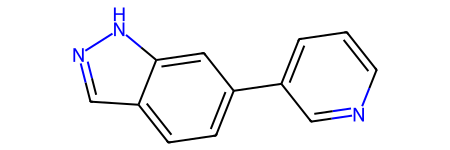

In [230]:
s = df['Smiles'][2329]
m = Chem.MolFromSmiles(s)
m

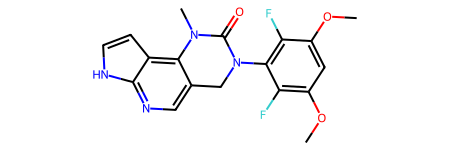

In [231]:
s = df['Smiles'][2108]
m = Chem.MolFromSmiles(s)
m

In [232]:
print(df['pChEMBL Value'][2108])

9.92


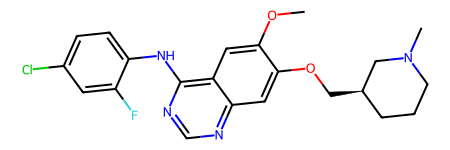

In [233]:
s = df['Smiles'][1]
m = Chem.MolFromSmiles(s)
m


In [234]:
print(df['pChEMBL Value'][1])

5.75


In [235]:
def generate_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    bi = {}
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, bitInfo=bi)
    return fingerprint, bi

In [237]:
'''
s2 = df['Smiles'][900]
mol2 = Chem.MolFromSmiles(s2)
fp2, bi2 = generate_morgan_fingerprint(s2)

tpls2 = [(mol2,x,bi2) for x in fp2.GetOnBits()]
Draw.DrawMorganBits(tpls2[0:],molsPerRow=5,legends=[str(x) for x in fp2.GetOnBits()][0:])
'''

"\ns2 = df['Smiles'][900]\nmol2 = Chem.MolFromSmiles(s2)\nfp2, bi2 = generate_morgan_fingerprint(s2)\n\ntpls2 = [(mol2,x,bi2) for x in fp2.GetOnBits()]\nDraw.DrawMorganBits(tpls2[0:],molsPerRow=5,legends=[str(x) for x in fp2.GetOnBits()][0:])\n"

In [252]:

a= set(fp.GetOnBits())
b= set(fp2.GetOnBits())
a.intersection(b)


NameError: name 'fp' is not defined

In [239]:
'''
allFingerprints = []
for i in range(len(df)):
  s = df['Smiles'][i]
  f, _ = generate_morgan_fingerprint(s)
  allFingerprints.append(list(f.GetOnBits()))
  '''

"\nallFingerprints = []\nfor i in range(len(df)):\n  s = df['Smiles'][i]\n  f, _ = generate_morgan_fingerprint(s)\n  allFingerprints.append(list(f.GetOnBits()))\n  "

In [240]:
def count_occurrences(list_of_lists):
    # Create an empty dictionary to store the counts
    counts = {}

    # Iterate over each list in the list of lists
    for sublist in list_of_lists:
        # Iterate over each number in the sublist
        for number in sublist:
            # Increment the count for the current number
            counts[number] = counts.get(number, 0) + 1

    return counts

In [241]:
'''
bits = [2048, 4096, 8192, 16394, 32784, 65568,131136]
mols = df['Smiles'].apply(Chem.MolFromSmiles).tolist()

unique = []
for bit in bits:
  FPs = []
  infos = []
  for mol in mols:
    info = {}
    FPs.append(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits = bit, bitInfo = info, useFeatures = True))
    infos.append(info)
  unique.append(np.logical_or.reduce(FPs).sum())

fig, ax = plt.subplots()
ax.plot(unique)
ax.set_xlabel('Number of Identifiers')
ax.set_ylabel('Number of activated identifiers')
xticks = plt.xticks(range(len(bits)),bits)
ax.yaxis.get_major_locator().set_params(integer=True)
'''

"\nbits = [2048, 4096, 8192, 16394, 32784, 65568,131136]\nmols = df['Smiles'].apply(Chem.MolFromSmiles).tolist()\n\nunique = []\nfor bit in bits:\n  FPs = []\n  infos = []\n  for mol in mols:\n    info = {}\n    FPs.append(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits = bit, bitInfo = info, useFeatures = True))\n    infos.append(info)\n  unique.append(np.logical_or.reduce(FPs).sum())\n\nfig, ax = plt.subplots()\nax.plot(unique)\nax.set_xlabel('Number of Identifiers')\nax.set_ylabel('Number of activated identifiers')\nxticks = plt.xticks(range(len(bits)),bits)\nax.yaxis.get_major_locator().set_params(integer=True)\n"

In [242]:
# Redefining Morgan Fingerprint Generator
def generate_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    bi = {}
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=131136, bitInfo=bi)
    
    return fingerprint

In [243]:
df['fingerprints'] = df['Smiles'].apply(generate_morgan_fingerprint)

In [244]:
df

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,AlogP,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,fingerprints
0,CHEMBL111197,NaN,427.29,5.05,COc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3...,IC50,'=',370.00,nM,6.43,...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL1907763,NaN,430.91,4.90,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OC[C@@H]1CCCN(...,IC50,'=',1800.00,nM,5.75,...,SINGLE PROTEIN,CHEMBL1135889,1,Scientific Literature,J Med Chem,2002.0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL150504,NaN,238.25,2.72,O=C(O)c1ccc2c(c1)ncn2-c1ccccc1,IC50,'=',28000.00,nM,4.55,...,SINGLE PROTEIN,CHEMBL1131521,1,Scientific Literature,J Med Chem,1998.0,CHEMBL3308860,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL332269,NaN,377.28,4.51,CCCCNc1ncc2cc(-c3c(Cl)cccc3Cl)c(=O)n(C)c2n1,IC50,'=',4480.00,nM,5.35,...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL113356,NaN,411.29,4.91,Cn1c(=O)c(-c2c(Cl)cccc2Cl)cc2cnc(NCc3ccccc3)nc21,IC50,'=',14000.00,nM,4.85,...,SINGLE PROTEIN,CHEMBL1131066,1,Scientific Literature,J Med Chem,1998.0,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,CHEMBL5173348,NaN,639.76,5.62,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(CCCCO...,IC50,'=',0.37,nM,9.43,...,SINGLE PROTEIN,CHEMBL5150061,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,INHIBITOR,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3528,CHEMBL189584,PD-173074,523.68,5.16,CCN(CC)CCCCNc1ncc2cc(-c3cc(OC)cc(OC)c3)c(NC(=O...,IC50,'=',26.20,nM,7.58,...,SINGLE PROTEIN,CHEMBL4632348,55,EUbOPEN Chemogenomic Library,NaN,NaN,CHEMBL3706569,NanoBRET Tracer: Tracer K10 | NanoBRET Tracer ...,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3529,CHEMBL5202912,NaN,638.73,4.79,COc1cc(OC)cc(N(CCNC(C)C)c2ccc3ncc(-c4cnn(CCC(=...,IC50,'=',0.38,nM,9.42,...,SINGLE PROTEIN,CHEMBL5150061,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,INHIBITOR,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3530,CHEMBL1336,SORAFENIB,464.83,5.55,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,IC50,'=',580.00,nM,6.24,...,SINGLE PROTEIN,CHEMBL5150004,1,Scientific Literature,J Med Chem,2021.0,NaN,NaN,INHIBITOR,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Making the Dataset**

In [245]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class yDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32)

class XDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [246]:
X_train = XDataset(PCA_data.iloc[0:2880])
y_train = yDataset(df['pChEMBL Value'][0:2880])
X_test = XDataset(PCA_data.iloc[2881:].reset_index(drop=True))
y_test = yDataset(df['pChEMBL Value'][2881:].reset_index(drop=True))
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)

In [247]:
a = pd.DataFrame(np.transpose(ipca.components_))

In [248]:
PCA_data = pd.Series(PCA_data)

In [249]:
PCA_data = np.zeros(3532, dtype=list)
for i in range(0, len(a)):
    PCA_data[i] = np.array(a.iloc[i].values)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


**PCA**

In [250]:
data = np.zeros(3532, dtype=list)
for i in range(0, len(df['fingerprints'])):
    data[i] = np.array(df['fingerprints'][i])
    if i % 100 == 0:
        print(i)


0
100
200
300
400
500
600
700
800


KeyboardInterrupt: 

In [ ]:
data[0]

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.vstack(data))



In [ ]:
np.save('scaled_data.npy',scaled_data )

In [ ]:
import numpy as np
X_scaled = np.transpose(np.load("/kaggle/input/scaled-fgfr/scaled_data.npy"))

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Specify the batch size for IPCA
batch_size = 1000

# Initialize IPCA with the desired number of components
n_components = 100
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Perform IPCA in batches
for i in range(0, X_scaled.shape[0], batch_size):
    batch = X_scaled[i:i + batch_size]
    ipca.partial_fit(batch)


In [ ]:
# Transform the entire dataset using IPCA
X_ipca = ipca.transform(X_scaled)

In [ ]:
# Step 6: Interpretation
print("Principal Components:")
components = ipca.components_


In [ ]:
import matplotlib.pyplot as plt
downsampled_data = np.mean(ipca.components_.reshape(100, -1, 3532), axis=2)
plt.figure(figsize=(20, 20))
plt.imshow(downsampled_data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Data')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

**Data Loaders**

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
shuffle = True

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Attention, self).__init__()
        self.W_query = nn.Linear(input_size, hidden_size)
        self.W_key = nn.Linear(input_size, hidden_size)
        self.W_value = nn.Linear(input_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):
        query = self.W_query(inputs)
        key = self.W_key(inputs)
        value = self.W_value(inputs)

        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32))
        attention_weights = self.softmax(scores)
        attended_values = torch.matmul(attention_weights, value)

        return attended_values, attention_weights


In [ ]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)  # Output layer for regression
        self.bn1 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.attention = Attention(100, 100)

    def forward(self, x):
        x, attention_weights = self.attention(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.bn1(x)
        x = nn.functional.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc5(x)
        return x, attention_weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model = RegressionModel(input_dim=100)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def evaluate_model(model, test_loader, criterion):
  running_loss = 0
  total_samples = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()  # Set model to evaluation mode

  with torch.no_grad():  # Disable gradient calculation
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs, attention_weights = model(inputs)
          outputs = torch.squeeze(outputs, dim=1)
          loss = criterion(outputs, targets)
          running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
          total_samples += inputs.size(0)  # Increment total samples

  avg_loss = running_loss / total_samples


  print("Validation Loss = " + str(avg_loss))
  return avg_loss


In [254]:
num_epochs = 50

# L1 regularization strength (lambda)
l1_lambda = 0.015

for epoch in range(num_epochs):
    last_loss = 9999999
    batches = 0
    model.train()
    for inputs, targets in train_loader: # training loop
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, attention_weights = model(inputs)
        outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, targets)

        # L1 Regularization
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.abs(param).sum()
        loss += l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        batches = batches + 1
        if batches % 10 == 0: # tracking batches
          print('batch ' + str(batches) + ' done of ' + str(len(train_loader)))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    valid_loss = evaluate_model(model, test_loader, criterion) # calculate valid loss
    if valid_loss < last_loss:
      last_loss = valid_loss
      torch.save(model.state_dict(), 'model1.pth') # if this is a new best, then save model.




batch 10 done of 90
batch 20 done of 90
batch 30 done of 90
batch 40 done of 90
batch 50 done of 90
batch 60 done of 90
batch 70 done of 90
batch 80 done of 90
batch 90 done of 90
Epoch [1/50], Loss: 3.1899
Validation Loss = 1.6694599389114322
batch 10 done of 90
batch 20 done of 90
batch 30 done of 90
batch 40 done of 90
batch 50 done of 90
batch 60 done of 90
batch 70 done of 90
batch 80 done of 90
batch 90 done of 90
Epoch [2/50], Loss: 2.1277
Validation Loss = 1.692813238606841
batch 10 done of 90
batch 20 done of 90
batch 30 done of 90
batch 40 done of 90
batch 50 done of 90
batch 60 done of 90
batch 70 done of 90
batch 80 done of 90
batch 90 done of 90
Epoch [3/50], Loss: 1.5076
Validation Loss = 1.6933404060735864
batch 10 done of 90
batch 20 done of 90
batch 30 done of 90
batch 40 done of 90
batch 50 done of 90
batch 60 done of 90
batch 70 done of 90
batch 80 done of 90
batch 90 done of 90
Epoch [4/50], Loss: 2.1582
Validation Loss = 1.6868317851456263
batch 10 done of 90
batch

In [ ]:
attention_weights